# Lab 09 XOR - Logistic Regression - Eager Excuetion
* XOR 문제를 Logistic Regression을 활용해 풀어보도록 하겠습니다.

### 기본 Library 선언 및 Tensorflow 버전 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()
tf.set_random_seed(777)  # for reproducibility

print(tf.__version__)

1.13.1


### 강의에 설명할 Data입니다
* x_data가 2차원 배열이기에 2차원 공간에 표현하여 x1과 x2를 기준으로 y_data 0과 1로 구분하는 예제입니다
* 붉은색과 푸른색으로 0과 1을 표시해 보도록 하겠습니다.

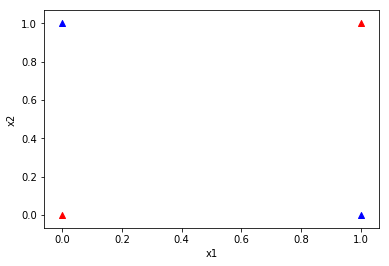

In [2]:
x_data = [[0, 0],
          [0, 1],
          [1, 0],
          [1, 1]]
y_data = [[0],
          [1],
          [1],
          [0]]

plt.scatter(x_data[0][0],x_data[0][1], c='red' , marker='^')
plt.scatter(x_data[3][0],x_data[3][1], c='red' , marker='^')
plt.scatter(x_data[1][0],x_data[1][1], c='blue' , marker='^')
plt.scatter(x_data[2][0],x_data[2][1], c='blue' , marker='^')

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

plt의 c/marker로 색과 표기법을 변경 가능 

https://matplotlib.org/3.1.0/api/markers_api.html
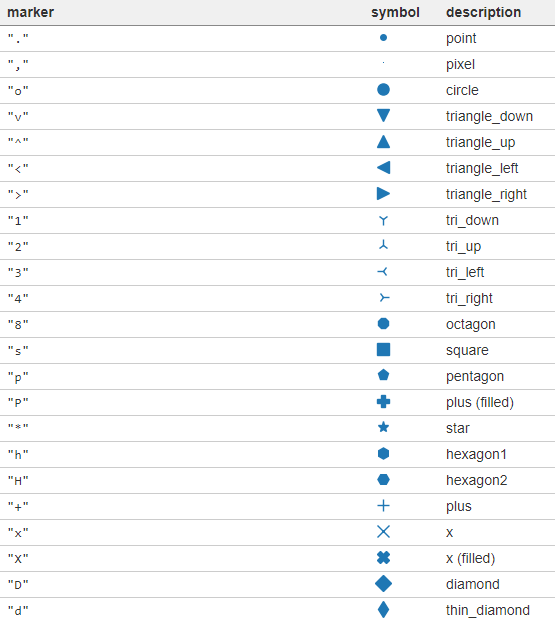


##  Tensorflow Eager
### 위 Data를 기준으로 XOR처리를 위한 모델을 만들도록 하겠습니다
* Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)
* preprocess function으로 features,labels는 실재 학습에 쓰일 Data 연산을 위해 Type를 맞춰준다

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).batch(len(x_data))

def preprocess_data(features, labels):
    features = tf.cast(features, tf.float32)
    labels = tf.cast(labels, tf.float32)
    return features, labels

tf.cast(condition)

condition에 따른 T/F return 



In [4]:
tt = tf.constant([11.0,12.5,16.0],tf.float32)
tt2 = [11,12,13,14,15]
print(tt)
oo = tf.cast(tt>14,tf.float32)
print(oo)
# list는 안됨..
#oo2 = tf.cast(tt2>14,tf.float32)
#print(oo2)

tf.Tensor([11.  12.5 16. ], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


## 1) Logistic Regression으로 XOR모델을 만들어 보겠습니다
### W와 b은 학습을 통해 생성되는 모델에 쓰이는 Wegith와 Bias (초기값을 variable : 0이나 Random값으로 가능 tf.random_normal([2, 1]) )

In [5]:
W = tf.Variable(tf.zeros([2,1]), name='weight')
b = tf.Variable(tf.zeros([1]), name='bias')
print("W = {}, B = {}".format(W.numpy(), b.numpy()))

W = [[0.]
 [0.]], B = [0.]


### Sigmoid 함수를 가설로 선언합니다
* Sigmoid는 아래 그래프와 같이 0과 1의 값만을 리턴합니다 tf.sigmoid(tf.matmul(X, W) + b)와 같습니다

$$
\begin{align}
sigmoid(x) & = \frac{1}{1+e^{-x}}  \\\\\
\end{align}
$$

In [6]:
def logistic_regression(features):
    hypothesis  = tf.div(1., 1. + tf.exp(tf.matmul(features, W) + b))
    return hypothesis

### 가설을 검증할 Cost 함수를 정의합니다
$$
\begin{align}
cost(h(x),y) & = −log(h(x))  &  if  &  y=1 \\\\\
cost(h(x),y) & = -log(1−h(x))  &  if  &  y=0
\end{align}
$$

* 위 두수식을 합치면 아래과 같습니다
$$
\begin{align}
cost(h(x),y) & = −y log(h(x))−(1−y)log(1−h(x))
\end{align}
$$

In [7]:
def loss_fn(hypothesis, features, labels):
    cost = -tf.reduce_mean(labels * tf.log(logistic_regression(features)) + (1 - labels) * tf.log(1 - hypothesis))
    return cost

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

### 추론한 값은 0.5를 기준(Sigmoid 그래프 참조)로 0과 1의 값을 리턴합니다.
* Sigmoid 함수를 통해 예측값이 0.5보다 크면 1을 반환하고 0.5보다 작으면 0으로 반환합니다.

In [8]:
def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

### GradientTape를 통해 경사값을 계산합니다.

In [9]:
def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(logistic_regression(features),features,labels)
    return tape.gradient(loss_value, [W,b])

### Tensorflow를 통한 실행을 위해 Session를 선언합니다.
* 위의 Data를 Cost함수를 통해 학습시킨 후 모델을 생성합니다. 

In [10]:
EPOCHS = 1001

for step in range(EPOCHS):
    for features, labels  in tfe.Iterator(dataset):
        features, labels = preprocess_data(features, labels)
        grads = grad(logistic_regression(features), features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))
        if step % 100 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, loss_fn(logistic_regression(features),features,labels)))
print("W = {}, B = {}".format(W.numpy(), b.numpy()))
x_data, y_data = preprocess_data(x_data, y_data)
test_acc = accuracy_fn(logistic_regression(x_data),y_data)
print("Testset Accuracy: {:.4f}".format(test_acc))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Iter: 0, Loss: 0.6931
Iter: 100, Loss: 0.6931
Iter: 200, Loss: 0.6931
Iter: 300, Loss: 0.6931
Iter: 400, Loss: 0.6931
Iter: 500, Loss: 0.6931
Iter: 600, Loss: 0.6931
Iter: 700, Loss: 0.6931
Iter: 800, Loss: 0.6931
Iter: 900, Loss: 0.6931
Iter: 1000, Loss: 0.6931
W = [[0.]
 [0.]], B = [0.]
Testset Accuracy: 0.5000
